In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import os.path as osp
import cv2
from vehicle_reid.embedder import Embedder
from vehicle_reid.evaluate import Evaluator
from vehicle_reid import exp_config
from vehicle_reid.common import *
from sift_match.sift_match import *
from matplotlib import pyplot as plt
from classifier import classifier_common as clscom
import tensorflow as tf
import numpy as np
import h5py
from PIL import Image
EXP_ROOT = "/home/hthieu/AICityChallenge2019/track2_experiments/"
EXP_ID = "180419_triplet-reid_pre-trained_densenet161_track2_small_512/"
# EXP_ID = "270419_triplet-reid_pre-trained_densenet161_track2_small"
GPU_ID = "1"
EXP_DIR = os.path.join(EXP_ROOT,EXP_ID)
VIEW_QUE = os.path.join(EXP_DIR, "que_views.h5")

In [2]:
train_cfg = TRAIN_BUS
test_cfg  = TEST_BUS
query_cfg = QUERY
test_full_cfg = TESTFULL
train_full_cfg = TRAINFULL

In [4]:
#READ EMB BUS RESULTS
train_emb, train_id, train_track = load_emb_h5(train_cfg['out_h5'])
test_emb, test_id, test_track = load_emb_h5(test_cfg['out_h5'])
test_full_emb, test_full_id, test_full_track = load_emb_h5(test_full_cfg['out_h5'])
train_full_emb, train_full_id, train_full_track = load_emb_h5(train_full_cfg['out_h5'])

query_emb, _, __ = load_emb_h5(query_cfg['out_h5'])
train_ids, train_paths, train_track = read_csv_dataset(train_cfg['csv_in'])
test_ids, test_paths, test_track = read_csv_dataset(test_cfg['csv_in'])
_, query_paths, __ = read_csv_dataset(query_cfg['csv_in'])

test_full_ids, test_full_paths, test_full_track = read_csv_dataset(test_full_cfg['csv_in'])
train_full_ids, train_full_paths, train_full_track = read_csv_dataset(train_full_cfg['csv_in'])

train_uni, truid = np.unique(train_track, return_index=True)
test_uni,teuid = np.unique(test_track,  return_index=True)

test_full_uni, tefuid = np.unique(test_full_track,  return_index=True)
train_full_uni, trfuid = np.unique(train_full_track,  return_index=True)

dict_train3imgs = get3avt("train")
dict_test3imgs = get3avt("test")
train3 = np.array([np.argwhere(np.array(train_paths) == np.array(dict_train3imgs[x])[:,None])[:,1] for x in train_uni])
test3  = np.array([np.argwhere(np.array(test_paths) == np.array(dict_test3imgs[x])[:,None])[:,1] for x in test_uni])
trainfull3 = np.array([np.argwhere(np.array(train_full_paths) == np.array(dict_train3imgs[x])[:,None])[:,1] for x in train_full_uni])
testfull3  = np.array([np.argwhere(np.array(test_full_paths) == np.array(dict_test3imgs[x])[:,None])[:,1] for x in test_full_uni])

train_paths = np.array([osp.join(train_cfg['root'], x) for x in train_paths])
test_paths = np.array( [osp.join(test_cfg['root'], x) for x in test_paths])
query_paths = np.array( [osp.join(query_cfg['root'], x) for x in query_paths])
test_full_paths_crop = np.array( [osp.join(TESTCROP['root'], x) for x in test_full_paths])
test_full_paths = np.array( [osp.join(test_full_cfg['root'], x) for x in test_full_paths])


train_full_paths = np.array( [osp.join(train_full_cfg['root'], x) for x in train_full_paths])
train_track_paths = np.array([train_paths[train_track == x][0] for x in train_uni])
test_track_paths = np.array([test_paths[test_track == x][0] for x in test_uni])
test_full_track_paths = np.array([test_full_paths[test_full_track == x][0] for x in test_full_uni])
test_full_track_paths_crop = np.array([test_full_paths_crop[test_full_track == x][0] for x in test_full_uni])

train_full_track_paths = np.array([train_full_paths[train_full_track == x][0] for x in train_full_uni])
train_uni_id = train_ids[np.array(truid)]
_, test_best_imgs, __ = read_csv_dataset("data/track2_test_best_imgs.csv")

query_emb_crop,_,__ = load_emb_h5(QUERYCROP['out_h5'])
test_emb_crop,_,__ = load_emb_h5(TESTCROP['out_h5'])

In [5]:
#USE ALL
train_track_emb = np.array([np.average(train_emb[train_track == x], axis = 0) for x in train_uni])
test_track_emb = np.array([np.average(test_emb[test_track == x], axis = 0) for x in test_uni])
test_full_track_emb = np.array([np.average(test_full_emb[test_full_track == x], axis = 0) for x in test_full_uni])
train_full_track_emb = np.array([np.average(train_full_emb[train_full_track == x], axis = 0) for x in train_full_uni])
test_full_track_emb_crop = np.array([np.average(test_emb_crop[test_full_track == x], axis = 0) for x in test_full_uni])

In [ ]:
#USE 3 AVT
train_track_emb = np.average(train_emb[train3],axis = 1)
test_track_emb = np.average(test_emb[test3],axis = 1)
print(testfull3.shape)
test_full_track_emb = np.average(test_full_emb[testfull3], axis = 1)
print(trainfull3.shape)
train_full_track_emb = np.average(train_full_emb[trainfull3], axis = 1)

In [6]:
evaluator = Evaluator(EXP_DIR, GPU_ID)

In [7]:
traintrain = evaluator.calculate_distances(train_track_emb,train_track_emb)
testtest = evaluator.calculate_distances(test_track_emb,test_track_emb)
testtrain = evaluator.calculate_distances(test_track_emb,train_track_emb)
# traintest = evaluator.calculate_distances(train_track_emb,test_track_emb)
querytest = evaluator.calculate_distances(query_emb, test_track_emb)
querytrain = evaluator.calculate_distances(query_emb, train_track_emb)
querytestfull = evaluator.calculate_distances(query_emb, test_full_track_emb)
querytrainfull = evaluator.calculate_distances(query_emb, train_full_track_emb)
traintestfull = evaluator.calculate_distances(train_track_emb, test_full_track_emb)
testfulltestfull = evaluator.calculate_distances(test_full_track_emb,test_full_track_emb)
trainfulltestfull = evaluator.calculate_distances(train_full_track_emb,test_full_track_emb)
queryquery = evaluator.calculate_distances(query_emb, query_emb)
testfulltrain = np.transpose(traintestfull)


(5, 5)

(10, 10)

(10, 5)

(1052, 10)

(1052, 5)

(1052, 798)

(1052, 1897)

(5, 798)

(798, 798)

(1897, 798)

(1052, 1052)


In [ ]:
save_dist(testfulltestfull,"test798x798")
save_dist(testfulltrain,"testfulltrainbus798x5")
save_dist(querytestfull,"querytestfull1052x798")
save_dist(queryquery,"queryquery1052x1052")

In [ ]:
#image base
img_querytest = evaluator.calculate_distances(query_emb, test_full_emb)
img_testtest = evaluator.calculate_distances(test_full_emb, test_full_emb)
# save_dist(img_querytest, "img_quetest_1052x18290")
# save_dist(img_testtest, "img_testtest_18290x18290")

In [10]:
QUERYVIEW = "vehicle_view_prediction/040519_query_view_0.96.csv"
TESTVIEW  = "vehicle_view_prediction/040519_test_view_0.96.csv"
queview = read_csv_view(QUERYVIEW)
testview = read_csv_view(TESTVIEW)
view_testtest = evaluator.calculate_distances(testview, testview)
view_quetest = evaluator.calculate_distances(queview, testview)


(18290, 18290)

(1052, 18290)


In [31]:
from scipy.spatial.distance import euclidean
k = 5
top3_quetest = np.zeros((len(query_paths), len(test_full_uni)))
for q in range(len(queview)):
    for trklet in test_full_uni:
        imgs_in_trklet = test_full_track == trklet
        test_selected_by_view = np.argsort(view_quetest[q,imgs_in_trklet])[:k]
        test_dist = np.average(test_full_emb[imgs_in_trklet][test_selected_by_view],axis = 0)
        top3_quetest[q,trklet] = euclidean(test_dist, query_emb[q])
top3_quetest.shape

(1052, 798)

In [32]:
from scipy.spatial.distance import euclidean
no_trklet = len(test_full_uni)
top3_testtest = np.zeros((no_trklet, no_trklet))
for i in range(no_trklet-1):
    trk1 = []
    for j in range(i+1, no_trklet):
        imgs_in_trklet_1 = test_full_track == i
        imgs_in_trklet_2 = test_full_track == j
        tmp = np.argsort(view_testtest[imgs_in_trklet_1][:,imgs_in_trklet_2].reshape(-1))[:k]
        x_trk1 = (tmp // np.sum(imgs_in_trklet_2))
        y_trk2 = (tmp % np.sum(imgs_in_trklet_2))
        trklet1_emb = np.average(test_full_emb[imgs_in_trklet_1][x_trk1],axis = 0)
        trklet2_emb = np.average(test_full_emb[imgs_in_trklet_2][y_trk2],axis = 0)
        dist = euclidean(trklet1_emb, trklet2_emb)
        top3_testtest[i,j] = dist
        top3_testtest[j,i] = dist

In [29]:
top3_testtest.shape

(798, 798)

In [30]:
save_dist(top3_testtest,"top3_test798x798")
save_dist(top3_quetest, "top3_quetest1052x798")

In [ ]:
gr_x = group_314
gr_y = group_623
dist_mat = img_testtest[gr_x][:,gr_y]
x , y = np.where(dist_mat == np.min(dist_mat))

In [ ]:
dist_mat = view_testtest[gr_x][:,gr_y]
x_view, y_view = np.where(dist_mat == np.min(dist_mat))

In [ ]:
img_x = test_full_paths[gr_x][x_view[0]]
img_y = test_full_paths[gr_y][y_view[0]]
print(img_x)
vis_img(img_x)
plt.figure()
print(img_y)
vis_img(img_y)

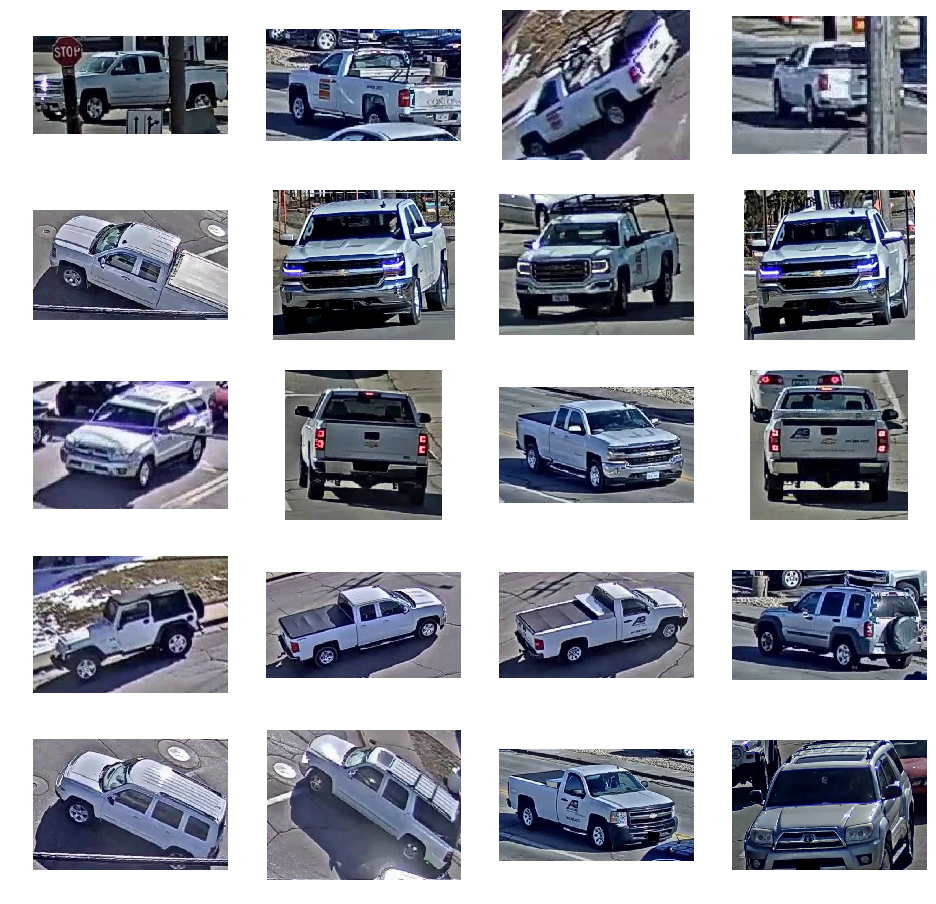

In [89]:
vis_img_group(test_full_track_paths[np.argsort(querytestfull[122,:])],4,5)

In [ ]:
img_x = test_full_paths[gr_x][x[0]]
img_y = test_full_paths[gr_y][y[0]]
print(img_x)
vis_img(img_x)
plt.figure()
print(img_y)
vis_img(img_y)

In [ ]:
#insert image to query
QUERY_ID = 28
print(query_paths[QUERY_ID])
vis_img(query_paths[QUERY_ID])
test_ranking = np.argsort(querytestfull[QUERY_ID,:])
train_ranking = np.argsort(querytrainfull[QUERY_ID,:])
closest_train_track = train_ranking[0]
closest_test_track = test_ranking[0]
print("Closest training track: ", closest_train_track)
print("Closest testing track: ", closest_test_track)

In [ ]:
# chay ra các tracklet tra ve voi anh query tuong ung
print(train_ranking[:20])
vis_img_group(train_full_track_paths[train_ranking[:20]],4,5)

In [ ]:
testcroptestcrop = evaluator.calculate_distances(test_full_track_emb_crop, test_full_track_emb_crop)
print(np.argsort(testcroptestcrop[217,:])[:30])
# print(np.argsort(testfulltestfull[217,:])[:30])
# print(test_full_paths_crop[np.argsort(testcroptestcrop[217,:])[:30]])
vis_img_group(test_full_track_paths_crop[np.argsort(testcroptestcrop[217,:])[:30]],5,6)

# EMBED CUSTOM IMAGES

In [ ]:
embedder = Embedder(exp_config.Track2Embedder.EXP_ID,GPU_ID)

In [ ]:
# IMG_PATH = train_full_track_paths[1219]
IMG_PATH = query_paths[118]#.replace("query", "query_crop")
vis_img(IMG_PATH)

In [ ]:
original_img = Image.open(IMG_PATH)
grayscale_img = original_img.convert('L')
transform_img = np.array(original_img, dtype = np.float32)#[:,original_img.size[0]//2:]
inp_img = np.array(grayscale_img, dtype= np.float32)[...,None].repeat(3, axis=2)
query_img = tf.convert_to_tensor(transform_img)
query_img_emb = embedder.embed_images(query_img[None,])

In [ ]:
img_to_tests = evaluator.calculate_distances(query_img_emb,test_full_track_emb)
vis_img_group(test_full_track_paths[np.argsort(img_to_tests[0,:])][:40])

In [ ]:
test_full_emb[118][0]
print(query_img_emb[]

In [ ]:
print(selected_list[:10])
result_score = querytestfull[988,selected_list[:10]]
result_track = selected_list[:10][np.argsort(result_score)]
# result = result[np.argsort(result[selected_list[:9]])]
# print(result)
# vis_img_group(test_full_track_paths[np.argsort(querytestfull[988,selected_list[:20]])],4,5)
vis_img_group(test_full_track_paths[result_track],4,5)

In [ ]:
querytestfull[988,86]

In [ ]:
x = test_full_track_paths[np.argsort(testfulltestfull[759,:])][:20]
vis_img_group(x)
print(np.argsort(testfulltestfull[759,:])[:20])

In [ ]:
y = np.argsort(testfulltestfull[771,:])[:20]
vis_img_group(test_full_track_paths[y])
selected_type = [get_majority_types(x, test_type_score) for x in y]
print(selected_type)

In [ ]:
vis_img_group(test_full_track_paths[np.argsort(querytestfull[28,:])[:20]])

In [ ]:
querytestfull.shape

In [ ]:
save_dist(testfulltestfull,"testxtest_798x798")
save_dist(querytestfull,"queryxtest_1052x798")

In [ ]:
vis_img_group(test_full_track_paths[np.argsort(testfulltestfull[746,:])],4,5)

# GROUP DISTANCE BY KNEAREST IMAGES

In [ ]:
imgA = query_emb[414]
K = 10
dist = evaluator.calculate_distances(imgA[None,], test_full_emb)
topK = np.squeeze(np.argsort(dist)[:,:K])
print(topK)

In [ ]:
vis_img_group(test_full_paths[topK])

In [ ]:
vis_img(query_paths[225])

# SIFT KEYPOINTS

In [ ]:
compare(osp.join("image_query",osp.basename(query_paths[QUERY_ID])),
        osp.join("image_test",test_best_imgs[328]),True)
# compare())

In [ ]:
# Lay hinh gan nhat trong . tap train va dem no di query tren tap test
test_tracklets_from_best_train_track = np.argsort(trainfulltestfull[closest_train_track,:])
print(test_tracklets_from_best_train_track[:20])
vis_img_group(test_full_track_paths[test_tracklets_from_best_train_track],4,5)

In [ ]:
visualize_keypoints(osp.join("image_query",osp.basename(query_paths[QUERY_ID])))

In [ ]:
visualize_keypoints(osp.join("image_test",osp.basename("017292.jpg")))

In [ ]:
[(x, compare(osp.join("image_query",osp.basename(query_paths[QUERY_ID])),
        osp.join("image_test",test_best_imgs[x]),False)) for x in test_ranking[:10]]

# RERANKING BY VEHI TYPE + VIEWS

In [ ]:
query_id, query_type_predict, query_type_score = clscom.read_csv_file("vehicle_type_prediction/030519_query_type_0.92.csv")
test_id, test_type_predict, test_type_score = clscom.read_csv_file("vehicle_type_prediction/030519_test_type_0.92.csv")
def get_majority_types(inp_tracklet, test_type_score):
    img_in_track = inp_tracklet == test_full_track
    return np.argmax(np.average(test_type_score[img_in_track], axis=0))
# print()
# print(get_majority_types(selected, test_type_score))

In [ ]:
imgs_in_track = test_full_track == 86
# vis_img_group(test_full_paths[imgs_in_track])
print(np.argmax(test_type_score[imgs_in_track], axis=1))
print(np.average(test_type_score[imgs_in_track], axis=0))
# print(clscom.get_majority(test_full_track, 86, test_type_score))

# SIMILAR VIEW

In [ ]:
QUERYVIEW = "vehicle_view_prediction/040519_query_view_0.96.csv"
TESTVIEW  = "vehicle_view_prediction/040519_test_view_0.96.csv"
queview = read_csv_view(QUERYVIEW)
testview = read_csv_view(TESTVIEW)

bow_res, bow_conf = read_bow_res("bow_a_Tiep/BoW_5crops.csv")

In [ ]:
testqueview = evaluator.calculate_distances(queview,testview)
save_dist(testqueview,"quetestview_1052x18290")

In [ ]:
def top_similar_view(query_id, track_id, testqueview, test_full_track):
    same_track_let = test_full_track == track_id
    imgs_in_tracklet = np.squeeze(np.argwhere(same_track_let))
    piority = np.argsort(testqueview[query_id][same_track_let])
    return imgs_in_tracklet[piority[0]]


QUE_ID = 4
DOUBLE_CHECK = [451,303,308]
similar_view = [top_similar_view(QUE_ID,x,testqueview, test_full_track) for x in DOUBLE_CHECK]
print(similar_view)

count = 0
# for i in bow_conf:
#     if len(bow_conf[i]) != 0:
#         if (bow_conf[i][0] > 10):
#             vis_img = [query_paths[i-1], "/home/hthieu/AICityChallenge2019/data/Track2Data/" + bow_res[i][0],
#                       "/home/hthieu/AICityChallenge2019/data/Track2Data/" + bow_res[i][1]]
#             print(vis_img)
#             vis_img_group(vis_img,3,1)
#             count+=1
# print(count)

In [ ]:
query_truck = np.logical_or(query_type_predict == 3, query_type_predict == 1)
print(np.sum(query_truck))
vis_img_group(query_paths[query_truck])
# query_paths[query_truck]

In [ ]:
i = 241
scores_track = 1/querytestfull
selected = select_NN(np.argmax(scores_track[i]),testfulltestfull)
selected_type = [get_majority_types(x, test_type_score) for x in selected]
query_type = query_type_predict[i]
print(selected_type)
print(selected)
print(query_type)
# scores_track[i] = re_ranking(selected, scores_track[i])

# TRUCK

In [ ]:
# Read bus classification:
query_truck, test_truck = read_truck_query_test()
print(test_truck)
vis_img_group(test_full_track_paths[test_truck])
print(query_truck)
vis_img_group(query_paths[query_truck])

In [ ]:
trainfulltestfull.shape

# BUS

In [ ]:
bus_to_nearest_imgs = evaluator.calculate_distances(query_emb[query_bus],test_full_emb)
bus_to_nearest_imgs = np.argmin(bus_to_nearest_imgs,axis=1)
print(test_full_track[bus_to_nearest_imgs])

In [ ]:
# Read bus classification:
query_bus, test_bus = read_bus_query_test()
print(test_bus)
vis_img_group(test_full_track_paths[test_bus])
vis_img_group(query_paths[query_bus])

In [ ]:
x = np.argsort(testfulltestfull[692,:])[:20]
print(x)
vis_img_group(test_full_track_paths[x],5,2)

In [ ]:
bus_id = 4
test_ranking = np.argsort(querytestfull[query_bus[bus_id],:])
print(query_paths[query_bus[bus_id]])
vis_img_group(test_full_track_paths[test_ranking],5,2)

In [ ]:
a = classify_2_type_bus(testfulltrain[test_bus])
print(a)
a[np.argsort(querytestfull[query_bus,:][:,test_bus])]

In [ ]:
np.sort(querytestfull[query_bus,:][:,test_bus])

In [ ]:
print(bus_res)
vis_img_group(test_full_track_paths[bus_res[2]],4,5)

In [ ]:
bus_type_mask[:,0][:,None]

In [ ]:
def query_bus_type(img_id):
    return np.argsort(querytrain[img_id])
vis_img(query_paths[646])
vis_img_group(train_track_paths[query_bus_type(646)])